# 1.1 Birth Rates

The data on US births, provided by the CDC is in `data/births.csv`.

Reproduce the following plot of births by gender over time given the data:

![](births_gender.png)

Note the `1e6` on the y axis for scale

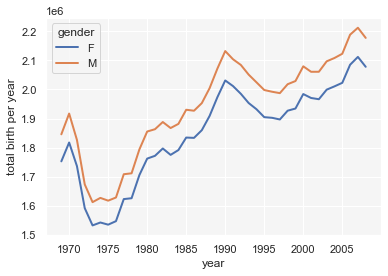

In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
import seaborn as sns

birth = pd.read_csv("data/births.csv")
fig, ax = plt.subplots()
#filtering data
birth.day = birth.day.fillna(0)
birth.day=birth.day.astype(int)
birth = birth[~birth.day.isin([99])]

#calculate for female
female = birth[birth['gender'] == 'F']
female_birth_total=female.groupby('year')\
                 .agg(total_birth=("births",'sum'))\
                 .reset_index()
#calculate for male
male = birth[birth['gender'] == 'M']
male_birth_total=male.groupby('year')\
                 .agg(total_birth=("births",'sum'))\
                 .reset_index()

#plotting graph
ax.plot(female_birth_total.year,female_birth_total.total_birth, '-',lw=2)
ax.plot(male_birth_total.year,male_birth_total.total_birth, '-',lw=2)

#styling graph
plt.xlabel('year')
plt.ylabel('total birth per year')
legend_labels = ['F','M']
plt.legend(legend_labels,title="gender")
#plt.grid(color = 'white')
#ax.set_facecolor(color = 'gray')
sns.set(rc={'axes.facecolor':'whitesmoke', 'figure.facecolor':'w'})

#print(male)
#print(male_birth_total)
# print(male_birth_total.index)
#birth

# 1.2 Births anomalies

This was analyzed by beloved statistician Andrew Gelman [here](http://andrewgelman.com/2012/06/14/cool-ass-signal-processing-using-gaussian-processes/), leading to this plot:

![](births_gp100.png)

Explain all three plots in Gelman's figure. 

**1.2:** What is the periodic component? What is the residual? Use your research skills to learn then explain it (in english).

Residual is the margin of error between the mean and the  observed value.

Periodic component is like periodic cycle. 
It flunctuates. 
Periodic component has 3 components. 
There is a trend, seasonal and irregular component. 
The birth period is particular based on a particular day/event. 



# 1.3 Holiday Anomalies Plot

Reproduce *as best you can* the first of the 3 figures from Andrew Gelman's blog post (your plot may have small differences)

**1.3.1:** Reproduce the births line in a plot. Hint: Make the x axis a `pd.datetime` object

**1.3.2:** Reproduce the `smoothed` line. Hint: use a rolling window average

**1.3.3:** Reproduce the entire figure with the mean line as a horizontal. You can make the y axis total births instead of a % deviation from mean axis (they'll look the same anyway)

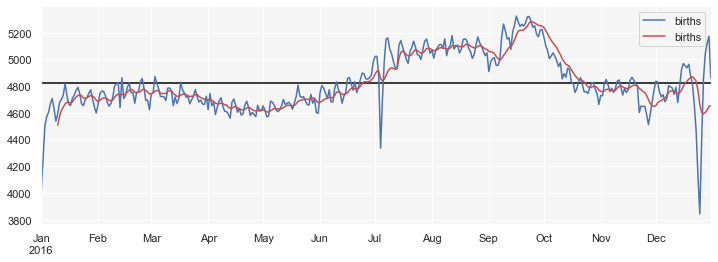

In [16]:
import datetime as dt
import warnings
warnings.filterwarnings('ignore')

birth = birth[~birth.day.isin([0])]
df=birth
df['date'] = pd.to_datetime(10000 * df.year +
                            100 * df.month +
                            df.day, format='%Y%m%d', errors='coerce')

quartiles = np.percentile(df['births'], [25, 50, 75])
mu = quartiles[1]
sig = 0.74 * (quartiles[2] - quartiles[0])
df = df.query('(births > @mu - 5 * @sig) & (births < @mu + 5 * @sig)')
df['day'] = df['day'].astype(int)
# create a datetime index from the year, month, day
df.index = pd.to_datetime(10000 * df.year +
                          100 * df.month +
                          df.day, format='%Y%m%d')
df = df.pivot_table('births', [df.index.month, df.index.day])
df.index = [pd.datetime(2016, month, day)
                        for (month, day) in df.index]
# # # Plot the results
fig, ax = plt.subplots(figsize=(12, 4))
df.plot(ax=ax)
df.rolling(window=10).mean().plot(color='r', ax=ax)
ax.hlines(df.births.mean(),df.index[0],df.index[-1],color = 'black')


# 2. Recipe Database

### 2.1 

Load the JSON recipe database we saw in lecture 4.

How many of the recipes are for breakfast food? Hint: The `description` would contain the work "breakfast"

In [18]:
import json
import gzip
import numpy as np
import pandas as pd
with gzip.open('data/recipe.json.gz','r') as f:
    # Extract each line
    data = (line.strip().decode() for line in f)
    # Reformat so each line is the element of a list
    data_json = f"[{','.join(data)}]"
# read the result as a JSON
recipes = pd.read_json(data_json)
recipes.shape

(173278, 17)

In [19]:
recipes.description.str.contains("[Bb]reakfast", na=False).sum()

3524

### 2.2 A simple recipe recommender

Let's build a recipe recommender: given a list of basic ingredients, find a recipe that uses all those ingredients.

Here is the list of ingredients that can be asked for:

```
['salt', 'pepper', 'oregano', 'sage', 'parsley',
 'rosemary', 'tarragon', 'thyme', 'paprika', 'cumin']
```

**Hint:** Build a new column for each of the ingredients that indicates whether that ingredient is in the recipe.

**example:**
```
recommend_ingredients(["parsley", "paprika", "tarragon"], df)

result: 
# The rows where these 3 ingredients are in the recipe
[2069, 74964, 93768, 113926, 137686, 140530, 158475, 158486, 163175, 165243]
```

In [47]:
import re
import pandas as pd

def recommend_ingredients(list_of_ingredients, recipes):
    row_id = []
    spice_list = ['salt', 'pepper', 'oregano', 'sage', 'parsley', 'rosemary', 'tarragon', 'thyme', 'paprika', 'cumin']
    spice_df=pd.DataFrame(dict((spice, recipes.ingredients.str.contains(spice, re.IGNORECASE))
                             for spice in spice_list))
    join_ingredients = '&'.join(list_of_ingredients)
    row_id.append(spice_df.query(join_ingredients).index)
    return row_id

list_of_ingredients= ["parsley", "paprika", "rosemary"]
recommend_ingredients(list_of_ingredients, recipes)

[Int64Index([  4635,   4875,   5468,   5470,   6955,  12052,  66245,  67429,
              70209,  70655,  71443,  71793,  74265,  87168,  89794,  90652,
              97330, 101573, 105548, 106200, 114843, 131504, 165030, 165476,
             167105, 168089, 169167, 171491, 171724, 172905],
            dtype='int64')]

# 3. Movies!

Recall the [Movies Dataset](https://www.kaggle.com/rounakbanik/the-movies-dataset) from lecture 4. It's made up of several tables which we've played with in lecture 4.

The tables have common columns (`id` and `movie_id`) around which you can merge and join tables.

### 3.1 best director

Your task is to find **The best director** in terms of average ratings of his movies. This can be from the `ratings` or `ratings_small` table, or simply the vote average in the `metadata` table. The director can be found in the `cast` table.

You will have to use all of your skills to get this done, between using groupbys and merging multiple tables together

In [23]:
movies_url = {
"movies_metadata": "1RLvh6rhzYiDDjPaudDgyS9LmqjbKH-wh",
"keywords": "1YLOIxb-EPC_7QpkmRqkq9E6j7iqmoEh3",
"ratings": "1_5HNurSOMnU0JIcXBJ5mv1NaXCx9oCVG",
"credits": "1bX9othXfLu5NZbVZtIPGV5Hbn8b5URPf",
"ratings_small": "1fCWT69efrj4Oxdm8ZNoTeSahCOy6_u6w",
"links_small": "1fh6pS7XuNgnZk2J3EmYk_9jO_Au_6C15",
"links": "1hWUSMo_GwkfmhehKqs8Rs6mWIauklkbP",
}
def read_gdrive(url):
    """
    Reads file from Google Drive sharing link
    """
    path = 'https://drive.google.com/uc?export=download&id='+url
    return pd.read_csv(path)


In [28]:
credits = pd.read_csv("data/credits.csv")
mm = pd.read_csv("data/movies_metadata.csv")
kw = pd.read_csv("data/keywords.csv")
r = pd.read_csv("data/ratings.csv")
rs = pd.read_csv("data/ratings_small.csv")
ls = pd.read_csv("data/links_small.csv")
l = pd.read_csv("data/links.csv")


In [29]:
credits.crew = credits.crew.apply(lambda x: eval(x))

In [26]:
def find_director(crew):
    for person in crew:
        if person['job'] == 'Director':
            return person['name']

find_director(credits.crew[0])
print(credits.crew[0][0]['job'])

Director


In [30]:
#finding the names of Director
credits["Director"] = credits.crew.apply(find_director)
credits

,cast,crew,id,Director
0,"[{'cast_id': 14, 'character': 'Woody (voice)',...","[{'credit_id': '52fe4284c3a36847f8024f49', 'de...",862,John Lasseter
1,"[{'cast_id': 1, 'character': 'Alan Parrish', '...","[{'credit_id': '52fe44bfc3a36847f80a7cd1', 'de...",8844,Joe Johnston
2,"[{'cast_id': 2, 'character': 'Max Goldman', 'c...","[{'credit_id': '52fe466a9251416c75077a89', 'de...",15602,Howard Deutch
3,"[{'cast_id': 1, 'character': ""Savannah 'Vannah...","[{'credit_id': '52fe44779251416c91011acb', 'de...",31357,Forest Whitaker
4,"[{'cast_id': 1, 'character': 'George Banks', '...","[{'credit_id': '52fe44959251416c75039ed7', 'de...",11862,Charles Shyer
...,...,...,...,...
45471,"[{'cast_id': 0, 'character': '', 'credit_id': ...","[{'credit_id': '5894a97d925141426c00818c', 'de...",439050,Hamid Nematollah
45472,"[{'cast_id': 1002, 'character': 'Sister Angela...","[{'credit_id': '52fe4af1c3a36847f81e9b15', 'de...",111109,Lav Diaz
45473,"[{'cast_id': 6, 'character': 'Emily Shaw', 'cr...","[{'credit_id': '52fe4776c3a368484e0c8387', 'de...",67758,Mark L. Lester
45474,"[{'cast_id': 2, 'character': '', 'credit_id': ...","[{'credit_id': '533bccebc3a36844cf0011a7', 'de...",227506,Yakov Protazanov


In [31]:
#creating a new DF
idDirector = credits[['id','Director']]
print(idDirector)

           id          Director
0         862     John Lasseter
1        8844      Joe Johnston
2       15602     Howard Deutch
3       31357   Forest Whitaker
4       11862     Charles Shyer
...       ...               ...
45471  439050  Hamid Nematollah
45472  111109          Lav Diaz
45473   67758    Mark L. Lester
45474  227506  Yakov Protazanov
45475  461257     Daisy Asquith

[45476 rows x 2 columns]


In [38]:
#Merging IdDirector and ratings
merge_df = r.groupby('movieId').agg(avg_ratings_per_film=("rating",'mean')).reset_index()
director_ratings= pd.merge(idDirector,merge_df,
                        left_on  = 'id',
                        right_on ='movieId',
                        suffixes = ['_director_ratings','_merge_df'])
#finding the average ratings per film
director_ratings.avg_ratings_per_film.max()
director_ratings[director_ratings.avg_ratings_per_film == 5]
director_ratings.loc[director_ratings['avg_ratings_per_film']== np.max(director_ratings['avg_ratings_per_film'])]

          id         Director  movieId  avg_ratings_per_film
0        862    John Lasseter      862              3.598930
1       8844     Joe Johnston     8844              3.760163
2        949     Michael Mann      949              3.905544
3        710  Martin Campbell      710              2.740334
4       1408     Renny Harlin     1408              3.710181
...      ...              ...      ...                   ...
7566   98604    Sergey Ivanov    98604              3.795053
7567    5589    Bořivoj Zeman     5589              3.126140
7568   45527         Uwe Boll    45527              2.791667
7569   49280   Georges Méliès    49280              3.390625
7570  111109         Lav Diaz   111109              2.583333

[7571 rows x 4 columns]


,id,Director,movieId,avg_ratings_per_film
1307,27396,Douglas Hickox,27396,5.0
3327,95977,Felix E. Feist,95977,5.0
3979,172149,Andrew Birkin,172149,5.0
4475,173153,David Mamet,173153,5.0
4544,105526,Travis Fine,105526,5.0
4806,164278,George Schaefer,164278,5.0
5182,146946,Nick Vallelonga,146946,5.0
6124,129530,Kamal Ahmed,129530,5.0
6191,137853,Josh Koury,137853,5.0
6256,132912,Mimi Chakarova,132912,5.0


In [42]:
best_director = director_ratings.groupby('Director')\
                                .agg(avg_ratings_per_director=("avg_ratings_per_film",'mean'))\
                                .reset_index()

best_director.loc[best_director['avg_ratings_per_director']== np.max(best_director['avg_ratings_per_director'])]

,Director,avg_ratings_per_director
186,Andrew Birkin,5.0
1192,Felix E. Feist,5.0
1700,J.P. Dutta,5.0
2177,Josh Koury,5.0
2252,Kamal Ahmed,5.0
2882,Mike Dacko,5.0
2906,Mimi Chakarova,5.0
2991,Nick Vallelonga,5.0
3883,Steve Ball,5.0
4137,Travis Fine,5.0
